In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [ ]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

In [3]:
!nvidia-smi

Mon Feb 15 22:04:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.82       Driver Version: 451.82       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8     2W /  N/A |    134MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

## Read and Preprocessing Images

In [13]:
X_train = np.zeros((2300, 224, 224, 3))
X_test = np.zeros((805, 224, 224, 3))
index = np.random.choice(range(27), 20, replace=False)
not_index = list(set(range(27)) - set(index))
y_train = []
y_test = []

temp = np.zeros((27, 224, 224, 3))
for i in range(1, 116):
    folder = f'UTSig/Genuine/{i}'
    for index, filename in enumerate(os.listdir(folder)):
        temp[index, :, :, :] = cv2.resize(cv2.imread(
            os.path.join(folder, filename)), (224, 224)).astype('float16') / 255.
    y_train = y_train + [i] * 20
    y_test = y_test + [i] * 7
    X_train[(i-1)*20:i*20, :, :, :] = temp[index]
    X_test[(i-1)*7:i*7, :, :, :] = temp[not_index]

In [14]:
y_train = np.array(y_train)
y_train -= 1

y_test = np.array(y_test)
y_test -= 1

In [6]:
y_train = to_categorical(y_train, 115)
y_test = to_categorical(y_test, 115)

## ResNet 50

mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

In [7]:
base_model = keras.applications.ResNet50(input_shape=(224, 224, 3), classes=115, weights='imagenet', include_top=False)
base_model.trainable = False

In [8]:
x = keras.layers.Dropout(.5)(base_model.output)
x = keras.layers.GlobalAvgPool2D()(x)
# x = keras.layers.Dense(units=256, activation='relu')(x)
# x = keras.layers.Dropout(.5)(x)
x = keras.layers.Dense(units=115, activation='softmax')(x)
model = keras.models.Model(base_model.input, x)

In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[mc])
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=10, shuffle=True)

Epoch 1/10
72/72 [==============================] - 21s 224ms/step - loss: 4.5769 - accuracy: 0.1420 - val_loss: 3.4487 - val_accuracy: 0.3988
Epoch 2/10
72/72 [==============================] - 13s 186ms/step - loss: 2.4121 - accuracy: 0.8732 - val_loss: 2.6923 - val_accuracy: 0.5540
Epoch 3/10
72/72 [==============================] - 13s 187ms/step - loss: 1.2785 - accuracy: 0.9947 - val_loss: 2.2572 - val_accuracy: 0.6385
Epoch 4/10
72/72 [==============================] - 13s 187ms/step - loss: 0.7009 - accuracy: 1.0000 - val_loss: 2.0362 - val_accuracy: 0.6534
Epoch 5/10
72/72 [==============================] - 13s 187ms/step - loss: 0.4145 - accuracy: 1.0000 - val_loss: 1.9044 - val_accuracy: 0.6547
Epoch 6/10
72/72 [==============================] - 13s 187ms/step - loss: 0.2713 - accuracy: 1.0000 - val_loss: 1.8194 - val_accuracy: 0.6584
Epoch 7/10
72/72 [==============================] - 13s 187ms/step - loss: 0.1913 - accuracy: 1.0000 - val_loss: 1.7630 - val_accuracy: 0.6609

saved_model = keras.models.load_model('best_model.h5')

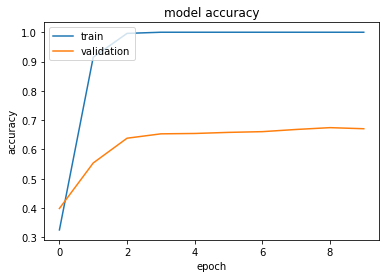

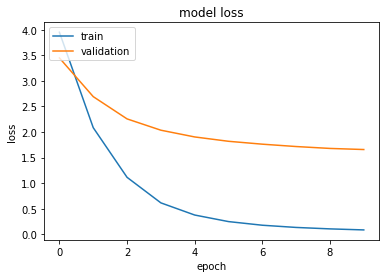

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Fine-tuning

In [12]:
base_model.trainable = True

In [13]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [17]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[mc])
history = model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=5, shuffle=True)

Epoch 1/5
144/144 [==============================] - 44s 304ms/step - loss: 5.3220 - accuracy: 0.3930 - val_loss: 23.8035 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 41s 287ms/step - loss: 1.1878 - accuracy: 0.7500 - val_loss: 25.9715 - val_accuracy: 0.0099
Epoch 3/5
144/144 [==============================] - 41s 288ms/step - loss: 0.2959 - accuracy: 0.9517 - val_loss: 23.7876 - val_accuracy: 0.0161
Epoch 4/5
144/144 [==============================] - 41s 288ms/step - loss: 0.0883 - accuracy: 0.9935 - val_loss: 21.9554 - val_accuracy: 0.0174
Epoch 5/5
144/144 [==============================] - 41s 287ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 20.0386 - val_accuracy: 0.0124


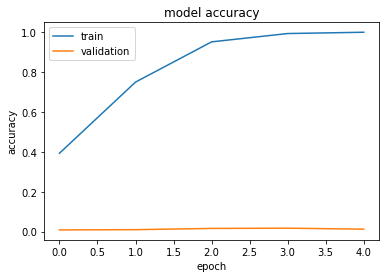

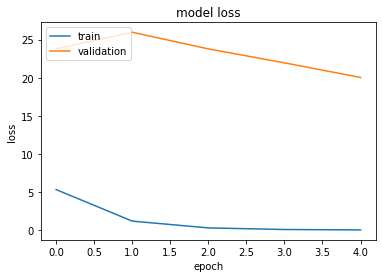

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Xception

In [7]:
base_model = keras.applications.Xception(input_shape=(224, 224, 3), classes=115, weights='imagenet', include_top=False, pooling='max')
base_model.trainable = False

In [8]:
x = keras.layers.Dense(units=256, activation='relu')(base_model.output)
x = keras.layers.Dropout(.5)(x)
x = keras.layers.Dense(units=115, activation='softmax')(x)
model = keras.models.Model(base_model.input, x)

In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[mc])
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=5, shuffle=True)

Epoch 1/5
36/36 [==============================] - 27s 592ms/step - loss: 4.0740 - accuracy: 0.1980 - val_loss: 2.9554 - val_accuracy: 0.4174
Epoch 2/5
36/36 [==============================] - 17s 462ms/step - loss: 0.7811 - accuracy: 0.8789 - val_loss: 2.1864 - val_accuracy: 0.5205
Epoch 3/5
36/36 [==============================] - 17s 462ms/step - loss: 0.1730 - accuracy: 0.9862 - val_loss: 1.9879 - val_accuracy: 0.5615
Epoch 4/5
36/36 [==============================] - 17s 462ms/step - loss: 0.0735 - accuracy: 0.9949 - val_loss: 1.9017 - val_accuracy: 0.5677
Epoch 5/5
36/36 [==============================] - 17s 462ms/step - loss: 0.0456 - accuracy: 0.9992 - val_loss: 1.8709 - val_accuracy: 0.5764


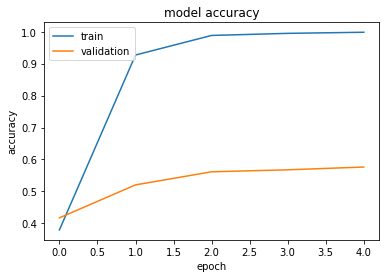

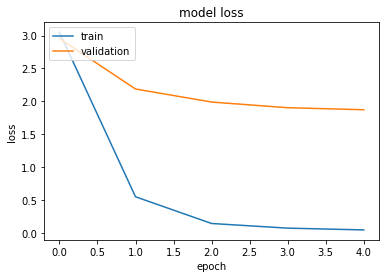

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### fine tuning

In [12]:
for i in range(1, 11):    
    base_model.layers[-i].trainable = True

In [13]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [14]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[mc])
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=5, shuffle=True)

Epoch 1/5
36/36 [==============================] - 23s 547ms/step - loss: 3.3518 - accuracy: 0.3324 - val_loss: 2.7951 - val_accuracy: 0.3913
Epoch 2/5
36/36 [==============================] - 18s 513ms/step - loss: 1.6672 - accuracy: 0.5995 - val_loss: 3.1656 - val_accuracy: 0.3453
Epoch 3/5
36/36 [==============================] - 18s 514ms/step - loss: 0.7390 - accuracy: 0.8280 - val_loss: 3.0415 - val_accuracy: 0.3578
Epoch 4/5
36/36 [==============================] - 18s 515ms/step - loss: 0.3812 - accuracy: 0.9202 - val_loss: 2.8326 - val_accuracy: 0.3752
Epoch 5/5
36/36 [==============================] - 18s 514ms/step - loss: 0.2883 - accuracy: 0.9458 - val_loss: 2.6102 - val_accuracy: 0.4050


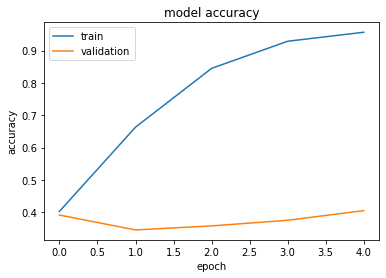

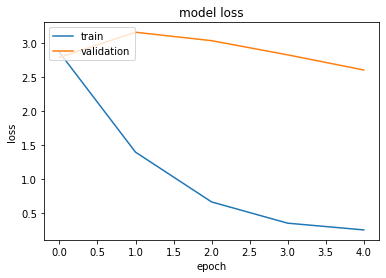

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Define a Model

In [22]:
input_layer = keras.Input((224, 224, 3))

x = keras.layers.Conv2D(16, 3, activation="relu")(input_layer)
x = keras.layers.Conv2D(16, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(32, 3, activation="relu")(x)
x = keras.layers.Conv2D(32, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(.5)(x)
output_layer = keras.layers.Dense(115, activation='softmax')(x)

model = keras.Model(input_layer, output_layer)

In [23]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [24]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[mc])
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=15, shuffle=True)

Epoch 1/15
36/36 [==============================] - 6s 163ms/step - loss: 4.7427 - accuracy: 0.0111 - val_loss: 4.7397 - val_accuracy: 0.0099
Epoch 2/15
36/36 [==============================] - 5s 152ms/step - loss: 4.7188 - accuracy: 0.0140 - val_loss: 4.6853 - val_accuracy: 0.0112
Epoch 3/15
36/36 [==============================] - 5s 152ms/step - loss: 4.4590 - accuracy: 0.0346 - val_loss: 4.2979 - val_accuracy: 0.0534
Epoch 4/15
36/36 [==============================] - 5s 152ms/step - loss: 3.2212 - accuracy: 0.2139 - val_loss: 4.3549 - val_accuracy: 0.0994
Epoch 5/15
36/36 [==============================] - 5s 153ms/step - loss: 1.6810 - accuracy: 0.5050 - val_loss: 4.7103 - val_accuracy: 0.1230
Epoch 6/15
36/36 [==============================] - 5s 153ms/step - loss: 0.7489 - accuracy: 0.7786 - val_loss: 5.4205 - val_accuracy: 0.1416
Epoch 7/15
36/36 [==============================] - 5s 153ms/step - loss: 0.3677 - accuracy: 0.8812 - val_loss: 5.8918 - val_accuracy: 0.1404
Epoch 

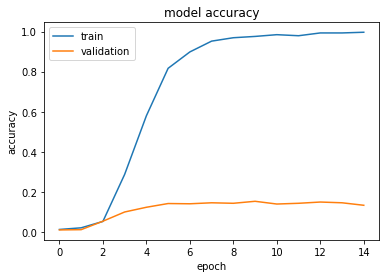

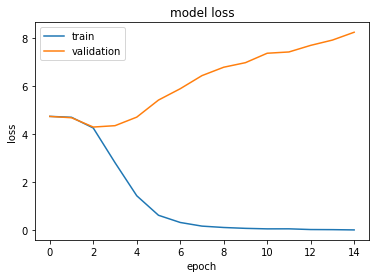

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## SVM

In [25]:
base_model = keras.applications.Xception(input_shape=(224, 224, 3), classes=115, weights='imagenet', include_top=False, pooling='max')

In [26]:
X = np.concatenate((X_train, X_test))

In [33]:
y = np.concatenate((y_train, y_test))

In [27]:
featurs = base_model.predict(X)

In [28]:
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']} 

In [29]:
test_fold = np.full(3105, -1)
test_fold[2300: ] = 0

In [30]:
ps = PredefinedSplit(test_fold)

In [31]:
model = GridSearchCV(SVC(), param_grid, refit=True, verbose=5, n_jobs=-1, cv=ps)

In [34]:
model.fit(featurs, y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    4.0s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.1s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=5)

In [35]:
model.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [36]:
test_features = base_model.predict(X_test)
print('accuracy: {0:.2f}'.format(model.score(test_features, y_test)))

accuracy: 1.00
